In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import joblib

In [226]:
df = pd.read_csv("/Users/ibrahimcaglar/Desktop/datasets/Codebasics/LogisticRegression/HR_comma_sep.csv")

In [228]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# Data Loading and Initial Cleaning

In [231]:
#We will not use "last_evaluation" column in this study
df = df.drop(columns = "last_evaluation", axis = 1)

#Let's change some column names
df.rename(columns={
    "number_project": "no_of_projects",
    "average_montly_hours": "average_monthly_hours",
    "time_spend_company": "time_spend_company(yrs)"
}, inplace=True)

In [233]:
# Let's move the "left" column to the end
cols = [col for col in df.columns if col != 'left'] + ['left']
df = df[cols]

In [235]:
df.head()

,satisfaction_level,no_of_projects,average_monthly_hours,time_spend_company(yrs),Work_accident,promotion_last_5years,Department,salary,left
0,0.38,2,157,3,0,0,sales,low,1
1,0.80,5,262,6,0,0,sales,medium,1
2,0.11,7,272,4,0,0,sales,medium,1
3,0.72,5,223,5,0,0,sales,low,1
4,0.37,2,159,3,0,0,sales,low,1


# Exploratory Data Analysis (EDA)

In [238]:
df["left"].value_counts()

left
0    11428
1     3571
Name: count, dtype: int64

- We will check f1 score as well as accuracy score because there are much less 1(left) values comparing to 0 values
- Use class_weight=balanced as well

In [241]:
df.groupby("left")["satisfaction_level"].mean()

left
0    0.666810
1    0.440098
Name: satisfaction_level, dtype: float64

#### Lower satisfaction levels are strongly associated with employees who left the company.

In [244]:
df.groupby("left")["no_of_projects"].mean()

left
0    3.786664
1    3.855503
Name: no_of_projects, dtype: float64

#### The average number of projects appears to have little impact on employee attrition.

In [247]:
df.groupby("left")["average_monthly_hours"].mean()

left
0    199.060203
1    207.419210
Name: average_monthly_hours, dtype: float64

#### Higher average monthly working hours are associated with employees who left the company.

In [250]:
df.groupby("left")["time_spend_company(yrs)"].mean()

left
0    3.380032
1    3.876505
Name: time_spend_company(yrs), dtype: float64

#### Time spent at the company does not appear to have a significant impact on whether an employee leaves.

In [253]:
pd.crosstab(df["Work_accident"], df["left"], normalize='index') * 100

left,0,1
Work_accident,,
0,73.484022,26.515978
1,92.208391,7.791609


#### Work accidents appear to be associated with lower attrition rates among employees.

In [256]:
pd.crosstab(df["promotion_last_5years"], df["left"], normalize='index') * 100

left,0,1
promotion_last_5years,,
0,75.803815,24.196185
1,94.043887,5.956113


#### Lack of promotion appears to be strongly associated with higher attrition rates.

In [259]:
# Department-wise attrition rate (%)
dept_left_ratio = df.groupby("Department")["left"].mean() * 100
dept_left_ratio = dept_left_ratio.sort_values(ascending=False)
print(dept_left_ratio)

Department
hr             29.093369
accounting     26.597132
technical      25.625000
support        24.899058
sales          24.492754
marketing      23.659674
IT             22.249389
product_mng    21.951220
RandD          15.374841
management     14.444444
Name: left, dtype: float64


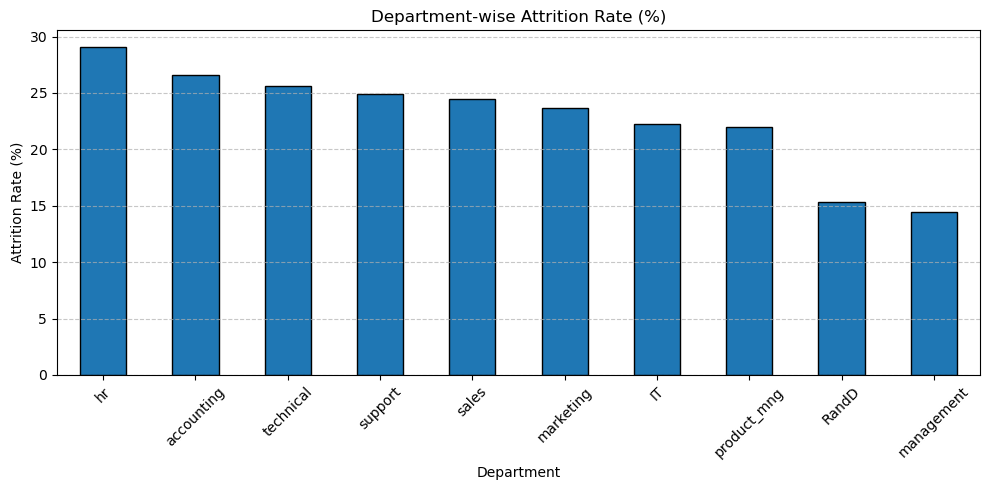

In [261]:
plt.figure(figsize=(10, 5))
dept_left_ratio.plot(kind="bar", edgecolor='black')
plt.title("Department-wise Attrition Rate (%)")
plt.xlabel("Department")
plt.ylabel("Attrition Rate (%)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### The attrition rate varies significantly across departments, with HR Department having the highest rate at 29%.

In [264]:
salary_left_ratio = df.groupby("salary")["left"].mean() * 100
salary_left_ratio = salary_left_ratio.sort_values(ascending=False)
print(salary_left_ratio)

salary
low       29.688354
medium    20.431275
high       6.628941
Name: left, dtype: float64


#### Employees with lower salaries are more likely to leave the company.

In [267]:
df.head()

,satisfaction_level,no_of_projects,average_monthly_hours,time_spend_company(yrs),Work_accident,promotion_last_5years,Department,salary,left
0,0.38,2,157,3,0,0,sales,low,1
1,0.80,5,262,6,0,0,sales,medium,1
2,0.11,7,272,4,0,0,sales,medium,1
3,0.72,5,223,5,0,0,sales,low,1
4,0.37,2,159,3,0,0,sales,low,1


In [269]:
X_columns = ["satisfaction_level", "average_monthly_hours", "Work_accident", "promotion_last_5years", "Department", "salary"]

# One Hot Encoding

In [272]:
df2 = pd.get_dummies(df, columns=["Department", "salary"], drop_first = True)

In [274]:
# Let's move the "left" column to the end
cols = [col for col in df2.columns if col != 'left'] + ['left']
df3 = df2[cols]

In [276]:
df3.head()

,satisfaction_level,no_of_projects,average_monthly_hours,time_spend_company(yrs),Work_accident,promotion_last_5years,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,salary_low,salary_medium,left
0,0.38,2,157,3,0,0,False,False,False,False,False,False,True,False,False,True,False,1
1,0.80,5,262,6,0,0,False,False,False,False,False,False,True,False,False,False,True,1
2,0.11,7,272,4,0,0,False,False,False,False,False,False,True,False,False,False,True,1
3,0.72,5,223,5,0,0,False,False,False,False,False,False,True,False,False,True,False,1
4,0.37,2,159,3,0,0,False,False,False,False,False,False,True,False,False,True,False,1


In [278]:
# Let's drop unnecessary columns we find from our EDA
df4 = df3.drop(columns=["no_of_projects", "time_spend_company(yrs)"])

In [280]:
df4.head()

,satisfaction_level,average_monthly_hours,Work_accident,promotion_last_5years,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,salary_low,salary_medium,left
0,0.38,157,0,0,False,False,False,False,False,False,True,False,False,True,False,1
1,0.80,262,0,0,False,False,False,False,False,False,True,False,False,False,True,1
2,0.11,272,0,0,False,False,False,False,False,False,True,False,False,False,True,1
3,0.72,223,0,0,False,False,False,False,False,False,True,False,False,True,False,1
4,0.37,159,0,0,False,False,False,False,False,False,True,False,False,True,False,1


# Standard Scaler

In [283]:
y = df4["left"]
X = df4.drop("left", axis = 1)

In [285]:
# Sadece bool sütunları int'e çevir
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

In [287]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [289]:
df4

,satisfaction_level,average_monthly_hours,Work_accident,promotion_last_5years,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,salary_low,salary_medium,left
0,0.38,157,0,0,False,False,False,False,False,False,True,False,False,True,False,1
1,0.80,262,0,0,False,False,False,False,False,False,True,False,False,False,True,1
2,0.11,272,0,0,False,False,False,False,False,False,True,False,False,False,True,1
3,0.72,223,0,0,False,False,False,False,False,False,True,False,False,True,False,1
4,0.37,159,0,0,False,False,False,False,False,False,True,False,False,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,151,0,0,False,False,False,False,False,False,False,True,False,True,False,1
14995,0.37,160,0,0,False,False,False,False,False,False,False,True,False,True,False,1
14996,0.37,143,0,0,False,False,False,False,False,False,False,True,False,True,False,1
14997,0.11,280,0,0,False,False,False,False,False,False,False,True,False,True,False,1


# Model Selection 

In [292]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [294]:
#Logistic Regression
model_lr = LogisticRegression(max_iter = 1000, class_weight = "balanced")

acc_scores = cross_val_score(model_lr, X_scaled, y, cv=cv, scoring='accuracy')
print("Accuracy Scores:", acc_scores)
print("Average Accuracy:", np.round(acc_scores.mean(), 4))

# F1
f1_scores = cross_val_score(model_lr, X_scaled, y, cv=cv, scoring='f1')
print("\nF1 Scores:", f1_scores)
print("Average F1 Score:", np.round(f1_scores.mean(), 4))

Accuracy Scores: [0.71066667 0.708      0.71466667 0.706      0.71257086]
Average Accuracy: 0.7104

F1 Scores: [0.53483387 0.53699789 0.53018661 0.53578947 0.54197662]
Average F1 Score: 0.536


In [296]:
#Decision Tree
model_dt = DecisionTreeClassifier()

acc_scores = cross_val_score(model_dt, X_scaled, y, cv=cv, scoring='accuracy')
print("Accuracy Scores:", acc_scores)
print("Average Accuracy:", np.round(acc_scores.mean(), 4))

# F1
f1_scores = cross_val_score(model_dt, X_scaled, y, cv=cv, scoring='f1')
print("\nF1 Scores:", f1_scores)
print("Average F1 Score:", np.round(f1_scores.mean(), 4))

Accuracy Scores: [0.938      0.93566667 0.93033333 0.93233333 0.93464488]
Average Accuracy: 0.9342

F1 Scores: [0.87061995 0.86950642 0.86124402 0.86720867 0.86597938]
Average F1 Score: 0.8669


In [298]:
#Support Vector Machine
model_svm = SVC(class_weight='balanced')

acc_scores = cross_val_score(model_svm, X_scaled, y, cv=cv, scoring='accuracy')
print("Accuracy Scores:", acc_scores)
print("Average Accuracy:", np.round(acc_scores.mean(), 4))

# F1
f1_scores = cross_val_score(model_svm, X_scaled, y, cv=cv, scoring='f1')
print("\nF1 Scores:", f1_scores)
print("Average F1 Score:", np.round(f1_scores.mean(), 4))

Accuracy Scores: [0.80066667 0.80966667 0.796      0.80566667 0.80026676]
Average Accuracy: 0.8025

F1 Scores: [0.6457346  0.65869695 0.6344086  0.65926359 0.65315576]
Average F1 Score: 0.6503


In [300]:
#Random Forest Classifier
model_rf = RandomForestClassifier(n_estimators = 20)

acc_scores = cross_val_score(model_rf, X_scaled, y, cv=cv, scoring='accuracy')
print("Accuracy Scores:", acc_scores)
print("Average Accuracy:", np.round(acc_scores.mean(), 4))

# F1
f1_scores = cross_val_score(model_rf, X_scaled, y, cv=cv, scoring='f1')
print("\nF1 Scores:", f1_scores)
print("Average F1 Score:", np.round(f1_scores.mean(), 4))

Accuracy Scores: [0.94833333 0.954      0.943      0.94766667 0.95098366]
Average Accuracy: 0.9488

F1 Scores: [0.89308176 0.89373681 0.88326301 0.89592124 0.89971751]
Average F1 Score: 0.8931


# Final Model Selection and Justification

After testing multiple classification algorithms, including Logistic Regression, Decision Tree, and Support Vector Machine, the **Random Forest Classifier** with `n_estimators=20` was selected as the final model.

The model achieves approximately 95% overall accuracy, meaning it correctly predicts whether an employee will stay or leave in 9.5 out of 10 cases.
Specifically, for predicting employees who actually leave, the model has an F1-score of around 90%, indicating moderate performance in identifying the minority class.

# Prediction

In [305]:
model_rf.fit(X_scaled, y)

RandomForestClassifier(n_estimators=20)

In [307]:
# Check the list of X columns - will use it during prediction
print(X.columns.tolist())

['satisfaction_level', 'average_monthly_hours', 'Work_accident', 'promotion_last_5years', 'Department_RandD', 'Department_accounting', 'Department_hr', 'Department_management', 'Department_marketing', 'Department_product_mng', 'Department_sales', 'Department_support', 'Department_technical', 'salary_low', 'salary_medium']


In [309]:
new_employee = [[
    0.1, 158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0 
]]

In [311]:
new_employee_df = pd.DataFrame(new_employee, columns=X.columns)
scaled_input = scaler.transform(new_employee_df)

In [313]:
#Prediction
prediction = model_rf.predict(scaled_input)
probability = model_rf.predict_proba(scaled_input)

message = (
    "This employee is likely to leave the company." if prediction[0] == 1
    else "This employee is likely to stay with the company."
)

print(message)

This employee is likely to leave the company.


# Joblib

In [170]:
joblib.dump(model_rf, 'model_rf.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns.tolist(), "feature_names.pkl")

['feature_names.pkl']

In [171]:
import os

print(os.listdir())

['.config', 'Music', 'SimpleLinearRegression.ipynb', 'scaler.pkl', 'RealEstatePricePredictionProject.ipynb', 'Folium_New.ipynb', '.condarc', 'Untitled1.ipynb', 'Folium.ipynb', '.DS_Store', 'HyperparameterTuning.ipynb', 'Project_HR.ipynb', 'Studentscores.ipynb', 'RandomForest.ipynb', '.CFUserTextEncoding', 'LogisticRegression_case.ipynb', '.xonshrc', 'OneHotEncoding.ipynb', 'anaconda_projects', 'Untitled.ipynb', 'banglore_home_prices', '.zshrc', 'crossval.ipynb', 'Audi_2.ipynb', 'model_rf.pkl', 'Pictures', 'medicalcost.ipynb', 'regressiontrees.ipynb', 'neuralnetwork.ipynb', 'Postman', 'LogisticRegressionMulticlass.ipynb', 'KNN.ipynb', 'heartattack.ipynb', '.zsh_history', 'Untitled2.ipynb', '.ipython', 'Desktop', 'Library', '.matplotlib', 'DecisionTree.ipynb', 'Amazon.ipynb', 'Project_Stock.ipynb', 'modelexercise.ipynb', 'columns.json', 'Training4.ipynb', 'rfexercise.ipynb', 'LogisticRegression.ipynb', 'plane_price_prediction.ipynb', 'PycharmProjects', 'Public', 'Training6.ipynb', 'insur